In [336]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('spark-bigquery-polyglot-language-demo') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-with-dependencies_2.12-0.25.2.jar') \
    .getOrCreate()

In [337]:
from pyspark.sql.functions import size, col, UserDefinedFunction
from pyspark.sql.types import StringType

# Load data from BigQuery.
df = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data.github_repos.languages') \
  .load()

# Cleaning up the data that does not have any languages.
# df = df.where(size(col("language")) > 0)
df.createOrReplaceTempView('df_view')
df.printSchema()

def preprocess_monorepo(arr) -> str:
    if len(arr) != 1:
        return None
    return arr[0].name

def preprocess_polyrepo(arr) -> str:
    if len(arr) < 2:
        return None
    arr.sort(key=lambda x : -x.bytes)
    sub = arr[:3]
    sub.sort(key=lambda x : x.name)
    ret = []
    for elem in sub:
        ret.append(elem.name)
    return ', '.join(ret)
    
udf_map = {
    "mono_language": (preprocess_monorepo, StringType()),
    "poly_language": (preprocess_polyrepo, StringType()),
}

for name, udf in udf_map.items():
    df = df.withColumn(name, UserDefinedFunction(*udf)(col("language")))

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



+--------------------+------+
|       poly_language|   cnt|
+--------------------+------+
|CSS, HTML, JavaSc...|250861|
|CSS, JavaScript, PHP| 71320|
|     CSS, JavaScript| 60504|
|    HTML, JavaScript| 53508|
|       Python, Shell| 33747|
|           CSS, HTML| 26973|
|     CSS, HTML, Ruby| 25080|
|HTML, JavaScript,...| 22137|
|   Objective-C, Ruby| 21534|
|HTML, JavaScript,...| 19844|
|         Ruby, Shell| 19761|
|CSS, JavaScript, ...| 18019|
|CSS, JavaScript, ...| 16900|
|    Assembly, C, C++| 14933|
|              C, C++| 13912|
|      CSS, HTML, PHP| 13059|
|CSS, Java, JavaSc...| 13033|
|      C, C++, Python| 12880|
|   CSS, HTML, Python| 12731|
|         Java, Shell| 11972|
+--------------------+------+
only showing top 20 rows



<AxesSubplot:ylabel='cnt'>

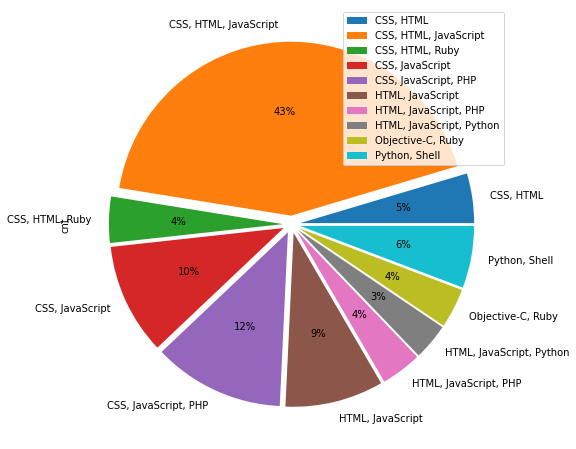

In [335]:

df.createOrReplaceTempView('mono_view')
df.createOrReplaceTempView('poly_view')

mono_ranking = spark.sql("""
    SELECT
        mono_view.mono_language, 
        count(mono_view.mono_language) AS cnt
    FROM 
        mono_view
    GROUP BY mono_view.mono_language
    ORDER BY
        cnt DESC
""")
mono_repos = mono_ranking.dropna()
# mono_repos.first()

poly_ranking = spark.sql("""
    SELECT
        poly_view.poly_language,
        count(poly_view.poly_language) AS cnt
    FROM
        poly_view
    GROUP BY poly_view.poly_language
    ORDER BY
        cnt DESC
""")
poly_ranking.show()

poly_panda = poly_ranking.toPandas()[:10].copy()
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
poly_panda.groupby(['poly_language']).sum().plot(kind='pie', y='cnt', autopct='%1.0f%%', figsize=(8, 8), explode=explode)

In [279]:
# seperate monoglot(single language used) repos and polyglot(multiple languages used) repos.
mono = df.where(size(col("language")) == 1)
mono.createOrReplaceTempView('mono_view')
poly = df.where(size(col("language")) > 1)
poly.createOrReplaceTempView('poly_view')
print(f"The number of repositories that use only one language is {mono.count()}")
print(f"The number of repositories that use multiple language is {poly.count()}")

The number of repositories that use only one language is 1203352


The number of repositories that use multiple language is 1752351


+-------------+------+
|         name|   cnt|
+-------------+------+
| [JavaScript]|203875|
|     [Python]|191117|
|       [Java]|183295|
|       [Ruby]|106335|
|        [PHP]| 96090|
|         [C#]| 57742|
|      [Shell]| 56174|
|         [Go]| 42849|
|[Objective-C]| 22485|
|        [C++]| 21984|
+-------------+------+



<AxesSubplot:ylabel='cnt'>

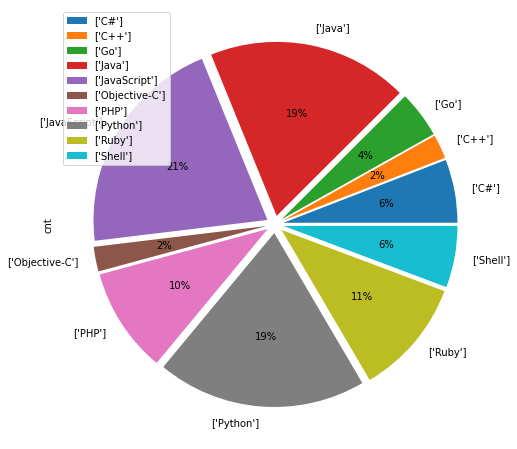

In [281]:
# Sort the monoglot repositories by the popularity of languages and see the top 10 languages.
ranking = spark.sql("""
    SELECT
        mono_view.language.name, 
        count(mono_view.language.name) AS cnt
    FROM 
        mono_view
    GROUP BY mono_view.language.name
    ORDER BY
        cnt DESC
    LIMIT 10
""")
ranking.show()
rank_panda = ranking.toPandas()
rank_panda = rank_panda.astype({"name": 'str'}, errors='raise')
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
rank_panda.groupby(['name']).sum().plot(kind='pie', y='cnt', autopct='%1.0f%%', figsize=(8, 8), explode=explode)

In [342]:
languages = spark.sql('''
SELECT DISTINCT elem.name
FROM df_view, UNNEST(language) as elem
''')
languages.show()

AnalysisException: cannot resolve '`language`' given input columns: []; line 3 pos 21;
'Distinct
+- 'Project ['elem.name]
   +- 'Join Inner
      :- SubqueryAlias df_view
      :  +- Relation[repo_name#3389,language#3390] com.google.cloud.spark.bigquery.direct.DirectBigQueryRelation@7482eaf
      +- 'SubqueryAlias elem
         +- 'UnresolvedTableValuedFunction UNNEST, ['language]


In [ ]:
# fcore = single.where(col('repo_name')=="Frankenhooker/FCore")
# fcore.select(col("repo_name"), col("language"), size(col("language"))).show()

# #standardSQL
# SELECT repo_name, elem.name, elem.bytes
# FROM `github_activity_data.languages`, UNNEST(language) as elem
# WHERE 
# ORDER BY elem.bytes DESC


# spark.sql('SELECT DISTINCT repo_name, language FROM single_view').show()
# single.withColumn("test", explode($"language")).show

# print(single, poly)
# print(_all, single, poly)
# single = df.select(col("repo_name"), col("language"), size(col("language"))
#     )
# single.show()
# df.groupBy(size(col("language"))).show()
# test_words.printSchema()

# Saving the data to BigQuery
# word_count.write.format('bigquery') \
#   .option('table', 'wordcount_dataset.wordcount_output') \
#   .save()


# Using UDF(User Defined Function), the actual plan is following.
# Create a new column named “dominant_language: string”.
# If len(language) == 0:
# dominant_language = null and drop the row.
# Else if len(language) == 1:
# dominant_language = language.name.
# Else if len(language) > 1:
# iterate the array
# Ignore languages if the percentage is less than 10%
# Choose top 3 languages in a repo to make a group
# In this case, these top 3 languages will not categorize well. Most of the combination of languages will be the part of web development.

# Instead of choose top 3 languages to group them, 


In [202]:
import pandas as pd
  
# DataFrame of each student and the votes they get
dataframe = pd.DataFrame({'Name': ['Aparna', 'Aparna', 'Aparna', 
                                   'Aparna', 'Aparna', 'Juhi', 
                                   'Juhi', 'Juhi', 'Juhi', 'Juhi',
                                   'Suprabhat', 'Suprabhat', 
                                   'Suprabhat', 'Suprabhat', 
                                   'Suprabhat'],
                          'votes_of_each_class': [12, 9, 17, 19, 
                                                  20, 11, 15, 12, 
                                                  9, 4, 22, 19, 17, 
                                                  19, 18]})
  
# Plotting the pie chart for above dataframe
print(dataframe.groupby(['Name']).sum())

           votes_of_each_class
Name                          
Aparna                      77
Juhi                        51
Suprabhat                   95
